**Hanane DUPOUY** ([linkedin](https://linkedin.com/in/hanane-d-algo-trader))

▶ Source/inspiration: deeplearning.ai x CrewAI short course "Multi AI Agent Systems with crewAI"

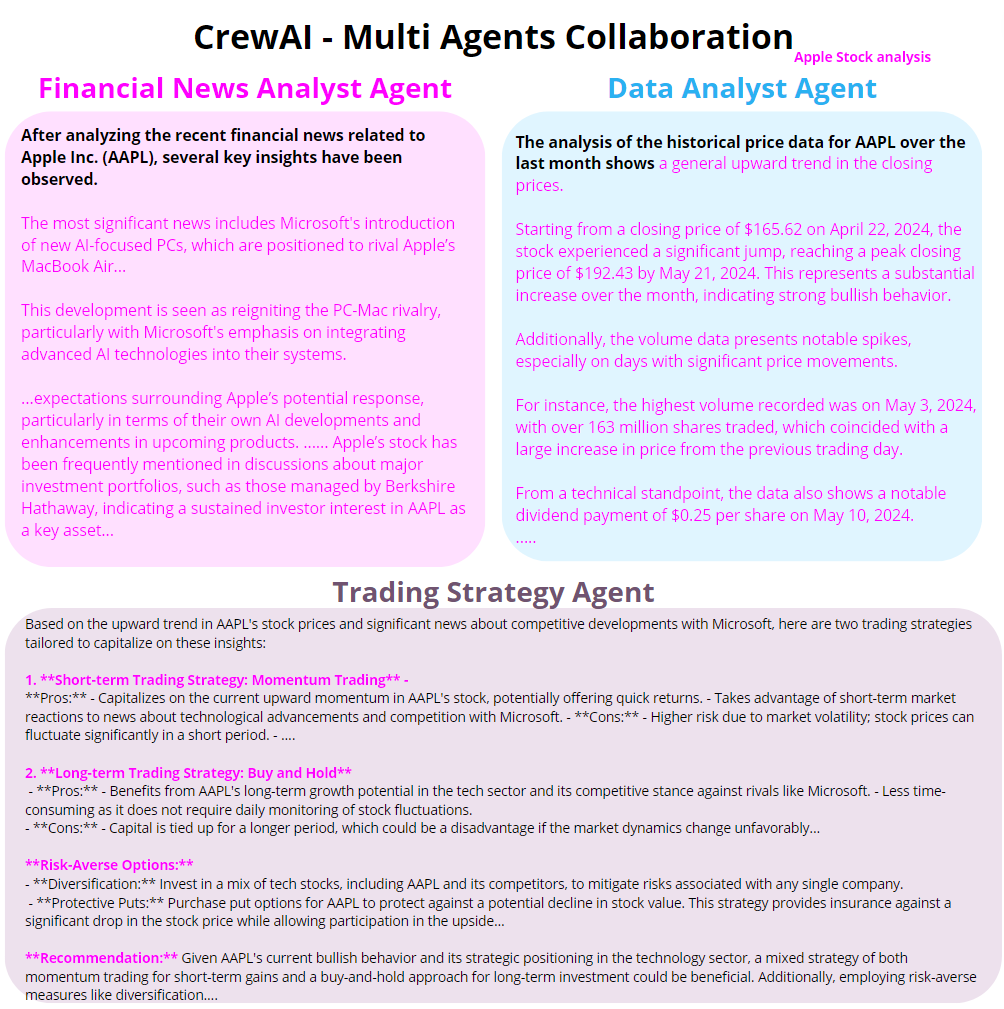

In [5]:
from PIL import Image
img = Image.open(local_path+'crewAI.png')
from IPython.display import display
display(img)

# Key Takeaway of CrewAI:

With CrewAI you can make several agents collaborate:


*   Each agent has a clear role, goal and a backstroy(description)
*   For each agent, you can specify a set of tools (crewAI tools, LangChain tools, or your own tools)
*   For each agent, you specify a task. It contains a description (instructions) and the expected ouputs. The task can also contains other parameters such as tools (overriding Agent tools), various outpout formats...
*   Then, you create the Crew, the manager, on which you specify your agents and their tasks (the order matter) and the process the agents need to follow to execute the tasks and provide the final answer.
*   The process involves how the agents collaborate with each other.
*   The one used is the Hierarchical process, in which the manager decices to which co-worker agent the next task will be delegated, and also handle the memory transition between the different agents. In this process, agents not only answer to the task but also refine the results of the other agents and ask for further improvements. Sequential process also exists.
*   Regardless of the choosen process, agents can also delegate tasks among themselves.

# Install Lib

In [ ]:
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29 -q

In [ ]:
from crewai import Agent, Task, Crew

In [ ]:
from google.colab import userdata
SERPER_API_KEY = userdata.get('SERPER_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

import os
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['SERPER_API_KEY'] = SERPER_API_KEY
os.environ["OPENAI_MODEL_NAME"] = 'gpt-4-turbo'
#this model will be used in crewai.Agent. If you don't specify it, it will use by default gpt-4 and the cost will be very expensive, especially when the defalult number of max iteration = 25 in agents.

Can't use 'gpt-4o' yet: the adequate tokenizer not yet available

KeyError('Could not automatically map gpt-4o to a tokeniser. Please use `tiktoken.get_encoding` to explicitly get the tokeniser you expect.') `Inline code`

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import date
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## My tools

In [ ]:
from crewai_tools import tool

@tool("Historical prices and volume for a ticker")
def stock_prices(ticker: str) -> pd.DataFrame:
    """
    Get the historical prices and volume for a ticker for the last month.

    Args:
    ticker (str): the stock ticker to be given to yfinance

    """
    stock = yf.Ticker(ticker)
    df = stock.history()
    return df

@tool("Most recent news of a stock or an instrument")
def stock_news(ticker: str) -> list:
    """
    Get the most recent news of a stock or an instrument from Yahoo Finance

    Args:
    ticker (str): the stock ticker to be given to yfinance
    """
    stock = yf.Ticker(ticker)
    list_news = stock.news
    return list_news

## CrewAI tools

In [ ]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

# Agents

In [ ]:
from crewai import Agent

data_analyst_agent = Agent(
    role="Data Analyst",
    goal="Monitor and analyze historical market data to identify trends.",
    backstory="Specializing in financial markets, this agent "
              "uses historical data statistical modeling to provide "
              "crucial insights on trends using on historical market data. "
              "The Data Analyst Agent plays a crucial role in guiding trading decisions.",
    verbose=True,
    allow_delegation=True,
    tools = [stock_prices],
    max_iter = 3,
)

news_analyst_agent = Agent(
    role="Financial News Analyst",
    goal="Collect and analyze financial news article to identify sentiment analysis and trends.",
    backstory="Specializing in financial news markets, this agent "
              "collects news article and summarize them to provide "
              "crucial insights on sentiment analysis and trends on a given instrument. "
              "The Financial News Analyst Agent plays a crucial role in guiding trading decisions.",
    verbose=True,
    allow_delegation=True,
    tools = [stock_news],
    max_iter = 3,
)


trading_strategy_agent = Agent(
    role="Trading Strategy Developer",
    goal="Propose and test various trading strategies based "
         "on insights from the Data Analyst Agent.",
    backstory="With an in-depth knowledge of financial markets "
              "and quantitative analysis, this agent "
              "proposes the most suitable trading strategies "
              "based on the Data Analyst agent insights."
              "It gives pros and cons for each strategy and risk-averse options.",
    verbose=True,
    allow_delegation=True,
    tools = [scrape_tool, search_tool],
    max_iter = 3
)
#Without code_interpreter like tool, it cannot perform calculation to evalute performances ...

execution_agent = Agent(
    role="Trade Advisor",
    goal="Suggest optimal trade execution strategies "
         "based on approved trading strategies.",
    backstory="This agent specializes in analyzing the timing, price, "
              "and logistical details of potential trades. By evaluating "
              "these factors, it provides well-founded suggestions for "
              "when and how trades should be executed to maximize "
              "efficiency and adherence to strategy.",
    verbose=True,
    allow_delegation=True,
    tools = [scrape_tool, search_tool],
    max_iter = 3
)

# Tasks

In [ ]:
from crewai import Task

# Task for Data Analyst Agent: Analyze Market Data
data_analysis_task = Task(
    description=(
        "Monitor and analyze market data for the selected stock ({stock_selection}). "
        "Use statistical modeling on historical prices to identify trends."
    ),
    expected_output=(
        "Insights and alerts about significant market "
        "opportunities, trends or threats for {stock_selection}."
    ),
    agent=data_analyst_agent,
)

# Task for Financial News Analyst Agent: Analyze Market Data
news_analysis_task = Task(
    description=(
        "Analyze news article for the selected stock ({stock_selection}). "
        "Extract sentiment analysis, financial analysts recommandations and key insights {news_impact_consideration}."
    ),
    expected_output=(
        "Sentiment analysis and insights from news articles for {stock_selection}."
    ),
    agent=news_analyst_agent,
)


# Task for Trading Strategy Agent: Develop Trading Strategies
strategy_development_task = Task(
    description=(
        "Develop and refine trading strategies based on: "
        "1- The insights from the Data Analyst agent."
        "2- The insights from the News Analyst agent."
        "3- User-defined risk tolerance ({risk_tolerance}). "
        "Consider trading preferences ({trading_strategy_preference})."
    ),
    expected_output=(
        "A set of potential trading strategies for {stock_selection} "
        "that align with the user's risk tolerance."
    ),
    agent=trading_strategy_agent,
)

# Task for Trade Advisor Agent: Plan Trade Execution
#I didn't modify much this task (from the course)
execution_planning_task = Task(
    description=(
        "Analyze approved trading strategies from the Trading Strategy Developer agent to determine the "
        "best execution methods for {stock_selection}. "
        "Consider the lowest market impact when executing."
        "Consider trends and sentiment analysis insights comming from the other agents."
    ),
    expected_output=(
        "Detailed execution plans suggesting how and when to "
        "execute trades for {stock_selection}."
    ),
    agent=execution_agent,
)

# Crew

In [ ]:
from crewai import Crew, Process
from langchain_openai import ChatOpenAI

# Define the crew with agents and tasks
financial_trading_crew = Crew(
    agents=[data_analyst_agent,
            news_analyst_agent,
            trading_strategy_agent,
            execution_agent],

    tasks=[data_analysis_task,
           news_analysis_task,
           strategy_development_task,
           execution_planning_task],

    manager_llm=ChatOpenAI(model="gpt-4-turbo", temperature=0),
    process=Process.hierarchical,
    verbose=True
)

In [ ]:
# Example data for kicking off the process
financial_trading_inputs = {
    'stock_selection': 'AAPL',
    'risk_tolerance': 'Medium',
    'trading_strategy_preference': 'Trend following Trading',
    'news_impact_consideration': True
}

### this execution will take some time to run
result = financial_trading_crew.kickoff(inputs=financial_trading_inputs)

 [DEBUG]: Working Agent: Crew Manager
 [INFO]: Starting Task: Monitor and analyze market data for the selected stock (AAPL). Use statistical modeling on historical prices to identify trends.


> Entering new CrewAgentExecutor chain...
Thought: To effectively monitor and analyze market data for AAPL, I need to start by gathering detailed historical price data and applying statistical modeling to identify trends. The Data Analyst is best suited for this task as they specialize in handling and analyzing large datasets.

Action: Delegate work to co-worker
Action Input: {"coworker": "Data Analyst", "task": "Analyze historical price data for AAPL", "context": "Collect and analyze historical price data for AAPL using statistical modeling techniques to identify trends. Focus on daily closing prices, volume, and any significant price movements over the past 5 years. Apply models such as moving averages, exponential smoothing, and regression analysis to determine trends and patterns. The goal is

In [ ]:
from IPython.display import Markdown
Markdown(result)

### Detailed Execution Plan for AAPL Trades

#### 1. **Preparation and Setup**
   - **Trading Platform**: Ensure access to a reliable trading platform that can handle high-frequency trading and is capable of setting advanced order types.
   - **Market Data Subscription**: Subscribe to real-time market data for AAPL and relevant economic indicators to stay updated.
   - **Alerts Setup**: Configure alerts for moving average crossovers (50-day crossing above 200-day for buys, and 50-day crossing below 200-day for sells).

#### 2. **Execution Strategy**
   - **Buy Signal**: Execute a buy order when the 50-day moving average crosses above the 200-day moving average. This indicates a bullish trend likely spurred by positive market reception to Apple's AI advancements.
     - **Timing**: Aim to execute during early trading hours when liquidity is higher, reducing market impact.
     - **Order Type**: Use limit orders set slightly above the current market price to avoid slippage.
   
   - **Sell Signal**: Execute a sell order when the 50-day moving average crosses below the 200-day moving average. This could reflect market corrections or negative reactions to competitive pressures from Microsoft.
     - **Timing**: Execute during mid-day trading to capitalize on typically higher trading volumes, which can help mask the trade.
     - **Order Type**: Use limit orders set slightly below the current market price for better control over the execution price.

#### 3. **Risk Management**
   - **Stop-Loss Orders**: Set stop-loss orders at 5-10% below the purchase price for all buys to mitigate potential losses from sudden market downturns.
   - **Position Sizing**: Limit the size of any single trade to no more than 10% of the total trading portfolio to manage exposure and risk.

#### 4. **Monitoring and Adjustments**
   - **Regular Strategy Reviews**: Conduct bi-weekly reviews of the trading strategy’s performance, particularly how the AI developments are influencing market dynamics.
   - **Adjustments**: Be prepared to adjust the strategy parameters (e.g., moving average periods, stop-loss levels) based on ongoing market conditions and performance analysis.

#### 5. **Market Considerations**
   - **AI Developments Impact**: Closely monitor news and developments regarding Apple’s and Microsoft’s AI technologies. Positive news about Apple's AI features could be used as an opportunity to increase positions, while advancements from Microsoft should prompt a review of potential risks.
   - **Competitive Landscape**: Keep an eye on how the competitive dynamics between Apple and Microsoft evolve, as these will influence investor sentiment and market movements.

This execution plan leverages the current market sentiment and the strategic use of moving average indicators to optimize trade executions for AAPL, aiming to capitalize on trends and minimize market impact. Regular updates and adjustments based on AI developments and competitive factors will help maintain the strategy's effectiveness.

# Final Thoughts

**The final result of the Crew gives broader insights that can be applied to any instrument. However intermediate answers from the different agents provide very insightful details.**

**The logic behind the agents and the co-workers concept is very promising. One needs to use specific tools and be more precise in the tasks to get the most of it.**